<a href="https://colab.research.google.com/github/TimeIsTheChoice/ColabCaffe/blob/master/02_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Caffe Prerpare

### cuda 10.0 install(match colab driver)
>optional


```
!nvidia-smi
!nvcc -V
```
run these code to check environment




In [1]:
!nvidia-smi
!nvcc -V

Wed Apr  1 02:30:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

if the output is
>**Cuda compilation tools, release 10.0, V10.0.130**

then we needn't run below code.


In [0]:
!apt  --purge remove "cublas*" "cuda*"
!apt  --purge remove "nvidia*" 
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub && sudo apt update
!dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
#!apt update
!apt install -y cuda=10.0.130-1

# Install CuDNN 7 and NCCL 2
!wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!dpkg -i nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

#!apt update
!apt install -y libcudnn7 libcudnn7-dev libnccl2 libc-ares-dev

!apt autoremove
#!apt upgrade

# Link libraries to standard locations
!mkdir -p /usr/local/cuda-10.0/nccl/lib
!ln -s /usr/lib/x86_64-linux-gnu/libnccl.so.2 /usr/local/cuda/nccl/lib/
!ln -s /usr/lib/x86_64-linux-gnu/libcudnn.so.7 /usr/local/cuda-10.0/lib64/

get GPU information

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11192613921550404442
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12440630070440008315
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1803576993715686997
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7210074816107499749
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


### Build Caffe

In [0]:
 !apt install python3-opencv
 !apt-get install libopenblas-dev # OpenBLAS
 # Other dependencies
!apt-get install libprotobuf-dev libleveldb-dev libsnappy-dev libopencv-dev libhdf5-serial-dev protobuf-compiler
!apt-get install — no-install-recommends libboost-all-dev
!apt-get install libgflags-dev libgoogle-glog-dev liblmdb-dev
!pip3 install protobuf
!apt-get install the python3-dev

#### clone caffe project
>rectified version

In [3]:
import os
os.chdir('/content')
!rm -rf caffe
!git clone https://github.com/TimeIsTheChoice/caffe.git
!cd caffe

Cloning into 'caffe'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 65304 (delta 12), reused 16 (delta 6), pack-reused 65277
Receiving objects: 100% (65304/65304), 74.40 MiB | 11.67 MiB/s, done.
Resolving deltas: 100% (41278/41278), done.


#### build caffe

>get CPU core number

In [4]:
!nproc --all
!echo "Threads/core: $(nproc --all)"

4
Threads/core: 4


>build pycaffe

In [0]:
import os
os.chdir('/content/caffe')
!make all -j$(nproc --all) # 4 represents number of CPU Cores
!make pycaffe -j$(nproc --all) # 4 represents number of CPU Cores

In [0]:
!export PYTHONPATH=~/caffe/python:$PYTHONPATH

#### import caffe

In [0]:
caffe_root = '/content/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

### GPU environment information



> make sure execute under gpu model



In [48]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

>check GPU memory utilization

In [49]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 23.9 GB  | Proc size: 4.4 GB
GPU RAM Free: 13525MB | Used: 2755MB | Util  17% | Total 16280MB


# Fine-tuning a Pretrained Network for Style Recognition

In this example, we'll explore a common approach that is particularly useful in real-world applications: take a pre-trained Caffe network and fine-tune the parameters on your custom data.

The advantage of this approach is that, since pre-trained networks are learned on a large set of images, the intermediate layers capture the "semantics" of the general visual appearance. Think of it as a very powerful generic visual feature that you can treat as a black box. On top of that, only a relatively small amount of data is needed for good performance on the target task.

First, we will need to prepare the data. This involves the following parts:
(1) Get the ImageNet ilsvrc pretrained model with the provided shell scripts.
(2) Download a subset of the overall Flickr style dataset for this demo.
(3) Compile the downloaded Flickr dataset into a database that Caffe can then consume.

In [0]:
caffe_root='/content/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

#### train with gpu

In [0]:
caffe.set_device(0)
caffe.set_mode_gpu()

#### deprocess image

In [0]:
import numpy as np
from pylab import *
%matplotlib inline
import tempfile

# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    #Negative values also work to make a copy of the same list in reverse order:
    #https://docs.python.org/2.3/whatsnew/section-slices.html
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

### 1. Setup and dataset download

Download data required for this exercise.

- `get_ilsvrc_aux.sh` to download the ImageNet data mean, labels, etc.
- `download_model_binary.py` to download the pretrained reference model
- `finetune_flickr_style/assemble_data.py` downloads the style training and testing data

We'll download just a small subset of the full dataset for this exercise: just 2000 of the 80K images, from 5 of the 20 style categories.  (To download the full dataset, set `full_dataset = True` in the cell below.)

#### Dataset Prepare
>download image and save train.txt


```
/content/caffe/data/flickr_style/images/10344996196_1117743cfe.jpg 0
/content/caffe/data/flickr_style/images/10878451835_36f42c8288.jpg 0
/content/caffe/data/flickr_style/images/2219475505_cddf77b23f.jpg 3
/content/caffe/data/flickr_style/images/13303239423_a3fa85f3ea.jpg 4
/content/caffe/data/flickr_style/images/12381079055_d882dfca2a.jpg 4
/content/caffe/data/flickr_style/images/2741691006_dd6bd8916f.jpg 3
/content/caffe/data/flickr_style/images/12764843585_bfdf0682bc.jpg 2
/content/caffe/data/flickr_style/images/12860689133_7b1c3da259.jpg 4
/content/caffe/data/flickr_style/images/8530766395_4229f47bf4.jpg 0
/content/caffe/data/flickr_style/images/13244554423_1afcabc4bf.jpg 1
···························
```



In [0]:
# Download just a small subset of the data for this exercise.
# (2000 of 80K images, 5 of 20 labels.)
# To download the entire dataset, set `full_dataset = True`.
full_dataset = False
if full_dataset:
    NUM_STYLE_IMAGES = NUM_STYLE_LABELS = -1
else:
    NUM_STYLE_IMAGES = 2000
    NUM_STYLE_LABELS = 5

# This downloads the ilsvrc auxiliary data (mean file, etc),
# and a subset of 2000 images for the style recognition task.
import os
os.chdir(caffe_root)  # run scripts from caffe root
!data/ilsvrc12/get_ilsvrc_aux.sh
#download the pretrained reference model
!scripts/download_model_binary.py models/bvlc_reference_caffenet
#downloads the style training and testing data
!python examples/finetune_flickr_style/assemble_data.py \
    --workers=-1  --seed=1701 \
    --images=$NUM_STYLE_IMAGES  --label=$NUM_STYLE_LABELS
# back to examples
os.chdir('examples')

#### load trained weight
Define `weights`, the path to the ImageNet pretrained weights we just downloaded, and make sure it exists.

In [0]:
import os
weights = os.path.join(caffe_root, 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
assert os.path.exists(weights)

#### load labels
>Load the 1000 ImageNet labels from `ilsvrc12/synset_words.txt`

> 5 style labels from `finetune_flickr_style/style_names.txt`

In [325]:
# Load ImageNet labels to imagenet_labels
imagenet_label_file = caffe_root + 'data/ilsvrc12/synset_words.txt'#downloaded by get_ilsvrc_aux.sh
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000
print('Loaded ImageNet labels:\n')
print('\n'.join(imagenet_labels[:10] + ['...']))

# Load style labels to style_labels
style_label_file = caffe_root + 'examples/finetune_flickr_style/style_names.txt'
style_labels = list(np.loadtxt(style_label_file, str, delimiter='\n'))
if NUM_STYLE_LABELS > 0:
    style_labels = style_labels[:NUM_STYLE_LABELS]
print('\nLoaded style labels:\n', ', '.join(style_labels))

Loaded ImageNet labels:

n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark
n01496331 electric ray, crampfish, numbfish, torpedo
n01498041 stingray
n01514668 cock
n01514859 hen
n01518878 ostrich, Struthio camelus
...

Loaded style labels:
 Detailed, Pastel, Melancholy, Noir, HDR


### 2.  Defining nets

We'll start by defining `caffenet`, a function which initializes the *CaffeNet* architecture (a minor variant on *AlexNet*), taking arguments specifying the data and number of output classes.

#### 1)Define caffenet

##### rectify tempfile

/usr/lib/python3.6/tempfile.NamedTemporaryFile first line
```
def NamedTemporaryFile(mode='w', buffering=-1, encoding=None,
```



In [185]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        return f.name

type: <class 'dict'>


Now, let's create a *CaffeNet* that takes unlabeled "dummy data" as input, allowing us to set its input images externally and see what ImageNet classes it predicts.

#### 2)Create **imagenet_net**

In [270]:
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 227, 227]))
imagenet_net_filename = caffenet(data=dummy_data, train=False)
imagenet_net = caffe.Net(imagenet_net_filename, # defines the structure of the model
                         weights, # contains the trained weights
                         caffe.TEST)# use test mode (e.g., don't perform dropout)

<class 'caffe.proto.caffe_pb2.NetParameter'>


#### 3)Create untrained_style_net

##### Function style_net

>this fucntion use to deal with some preprocess


1.   Let others call it use simple arguments 

>>>Train all layers

>>>Only Train fc8




2.   Use ImageData layer load data



Define a function `style_net` which calls `caffenet` on data from the Flickr style dataset.

The new network will also have the *CaffeNet* architecture, with differences in the input and output:

- the input is the Flickr style data we downloaded, provided by an `ImageData` layer
- the output is a distribution over 20 classes rather than the original 1000 ImageNet classes
- the classification layer is renamed from `fc8` to `fc8_flickr` to tell Caffe not to load the original classifier (`fc8`) weights from the ImageNet-pretrained model

In [0]:
def style_net(train=True, learn_all=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'test'
    source = caffe_root + 'data/flickr_style/%s.txt' % subset
    transform_param = dict(mirror=train, 
                           crop_size=227,
                           mean_file=caffe_root + 'data/ilsvrc12/imagenet_mean.binaryproto')
    
    # Use ImageData Layer load data
    style_data, style_label = L.ImageData(
        transform_param=transform_param, 
        source=source,
        batch_size=50,
        new_height=256,
        new_width=256,
        ntop=2
        )
    
    return caffenet(data=style_data, label=style_label, train=train,
                    num_classes=NUM_STYLE_LABELS,
                    classifier_name='fc8_flickr',
                    learn_all=learn_all)

##### define **untrained_style_net**

Use the `style_net` function defined above to initialize `untrained_style_net`, a *CaffeNet* with input images from the style dataset and weights from the pretrained ImageNet model.


Call `forward` on `untrained_style_net` to get a batch of style training data.

In [272]:
untrained_style_net = caffe.Net(style_net(train=False, subset='train'),
                                weights,
                                caffe.TEST)
untrained_style_net.forward()#forward :a iter for test
style_data_batch = untrained_style_net.blobs['data'].data.copy()
style_label_batch = np.array(untrained_style_net.blobs['label'].data, dtype=np.int32)

<class 'caffe.proto.caffe_pb2.NetParameter'>


###  Running  nets



 

#### define test function
>  display prediction

Pick one of the style net training images from the batch of 50 (we'll arbitrarily choose #8 here).  Display it, then run it through `imagenet_net`, the ImageNet-pretrained network to view its top 5 predicted classes from the 1000 ImageNet classes.

Below we chose an image where the network's predictions happen to be reasonable, as the image is of a beach, and "sandbar" and "seashore" both happen to be ImageNet-1000 categories.  For other images, the predictions won't be this good, sometimes due to the network actually failing to recognize the object(s) present in the image, but perhaps even more often due to the fact that not all images contain an object from the (somewhat arbitrarily chosen) 1000 ImageNet categories. Modify the `batch_index` variable by changing its default setting of 8 to another value from 0-49 (since the batch size is 50) to see predictions for other images in the batch.  (To go beyond this batch of 50 images, first rerun the *above* cell to load a fresh batch of data into `style_net`.)

>The reason of why below line 4 is 
```
probs = net.forward(start='conv1')['probs'][0]
```

In [0]:
for blob in imagenet_net.blobs:
    print(blob)
# print("-----------")
# for param in imagenet_net.params:
#     print(param)

In [0]:
def disp_preds(net, image, labels, k=5, name='ImageNet'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print('top %d predicted %s labels = '%(k, name))
    print('\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k)))

def disp_imagenet_preds(net, image):
    disp_preds(net, image, imagenet_labels, name='ImageNet')

def disp_style_preds(net, image):
    disp_preds(net, image, style_labels, name='style')


#### Show image and label

actual label = Pastel


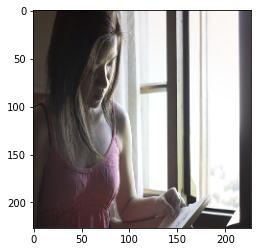

In [318]:
batch_index = 18
image = style_data_batch[batch_index]#load data
plt.imshow(deprocess_net_image(image))
print ('actual label =', style_labels[style_label_batch[batch_index]])#load actual label

#### use  imagenet to predict
>**untrained**

> imagenet load trained weight



In [334]:
disp_imagenet_preds(imagenet_net, image)
# for x in imagenet_net.forward(start='conv1'):
#  print(x)

top 5 predicted ImageNet labels = 
	(1) 18.70% n09468604 valley, vale
	(2) 18.45% n09332890 lakeside, lakeshore
	(3)  7.94% n09428293 seashore, coast, seacoast, sea-coast
	(4)  7.48% n09399592 promontory, headland, head, foreland
	(5)  7.40% n09193705 alp


We can also look at `untrained_style_net`'s predictions, but we won't see anything interesting as its classifier hasn't been trained yet.

In fact, since we zero-initialized the classifier (see `caffenet` definition -- no `weight_filler` is passed to the final `InnerProduct` layer), the softmax inputs should be all zero and we should therefore see a predicted probability of 1/N for each label (for N labels).  Since we set N = 5, we get a predicted probability of 20% for each class.

#### use  untrained_style_net to predict
>untrained

In [335]:
disp_style_preds(untrained_style_net, image)
# for x in untrained_style_net.forward(start='conv1'):
#  print(x)

top 5 predicted style labels = 
	(1) 20.00% Detailed
	(2) 20.00% Pastel
	(3) 20.00% Melancholy
	(4) 20.00% Noir
	(5) 20.00% HDR


We can also verify that the activations in layer `fc7` immediately before the classification layer are the same as (or very close to) those in the ImageNet-pretrained model, since both models are using the same pretrained weights in the `conv1` through `fc7` layers.

In [207]:
diff = untrained_style_net.blobs['fc7'].data[0] - imagenet_net.blobs['fc7'].data[0]
error = (diff ** 2).sum()
print(error)
assert error < 1e-8

1.4567725e-10


Delete `untrained_style_net` to save memory.  (Hang on to `imagenet_net` as we'll use it again later.)

In [0]:
del untrained_style_net

### 3. Training the style classifier

Now, we'll define a function `solver` to create our Caffe solvers, which are used to train the network (learn its weights).  In this function we'll set values for various parameters used for learning, display, and "snapshotting" -- see the inline comments for explanations of what they mean.  You may want to play with some of the learning parameters to see if you can improve on the results here!

#### define solver

In [0]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 10000  # Test after every 10000 training iterations.
        s.test_iter.append(1000) # Test on 1000 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'Adam'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 200000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = caffe_root + 'models/finetune_flickr_style/finetune_flickr_style'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

> Train use shell command

In [242]:
solver('/content/caffe/models/finetune_flickr_style/train_val.prototxt','/content/caffe/models/finetune_flickr_style/deploy.prototxt')

'/tmp/tmpwwhkrp6m'

> Here are some errors in it,the section exist is due to future improve(just skip it)

In [0]:
!/content/caffe/build/tools/caffe train \
    -solver  /tmp/tmpwwhkrp6m \
    -weights models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel \
    -gpu 0

Now we'll invoke the solver to train the style net's classification layer.

For the record, if you want to train the network using only the command line tool, this is the command:

<code>
build/tools/caffe train \
    -solver models/finetune_flickr_style/solver.prototxt \
    -weights models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel \
    -gpu 0
</code>

However, we will train using Python in this example.

We'll first define `run_solvers`, a function that takes a list of solvers and steps each one in a round robin manner, recording the accuracy and loss values each iteration.  At the end, the learned weights are saved to a file.

####  run_solver

In [0]:
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers} for _ in blobs)
    for it in range(niter):
        #save loss and acc per iter
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy() for b in blobs)
        #display loss and acc in particular iter
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print('%3d) %s' % (it, loss_disp)     )
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

#### train both of all only in last fc layer

Let's create and run solvers to train nets for the style recognition task.  We'll create two solvers -- one (`style_solver`) will have its train net initialized to the ImageNet-pretrained weights (this is done by the call to the `copy_from` method), and the other (`scratch_style_solver`) will start from a *randomly* initialized net.

During training, we should see that the ImageNet pretrained net is learning faster and attaining better accuracies than the scratch net.

In [0]:
niter = 2000  # number of iterations to train

# Reset style_solver as before.
style_solver_filename = solver(style_net(train=True))
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(weights)#load weight

# For reference, we also create a solver that isn't initialized from
# the pretrained ImageNet weights.
scratch_style_solver_filename = solver(style_net(train=True))
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)

print ('Running solvers for %d iterations...' % niter)
solvers = [('pretrained', style_solver),
           ('scratch', scratch_style_solver)]
loss, acc, weights = run_solvers(niter, solvers)
print ('Done.')

train_loss, scratch_train_loss = loss['pretrained'], loss['scratch']
train_acc, scratch_train_acc = acc['pretrained'], acc['scratch']
style_weights, scratch_style_weights = weights['pretrained'], weights['scratch']

# Delete solvers to save memory.
del style_solver, scratch_style_solver, solvers

##### training loss 

Let's look at the training loss and accuracy produced by the two training procedures.  Notice how quickly the ImageNet pretrained model's loss value (blue) drops, and that the randomly initialized model's loss value (green) barely (if at all) improves from training only the classifier layer.

Text(0, 0.5, 'Loss')

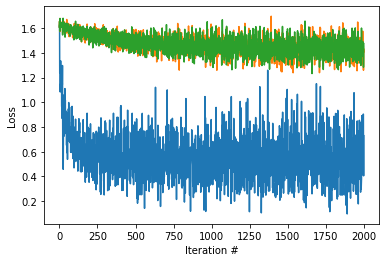

In [262]:
plot(np.vstack([train_loss, scratch_train_loss]).T)
xlabel('Iteration #')
ylabel('Loss')

##### training accuracy

Text(0, 0.5, 'Accuracy')

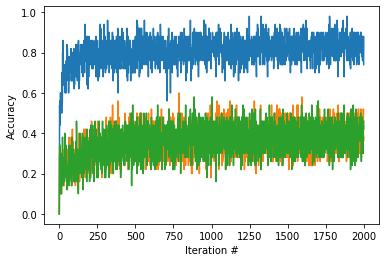

In [263]:
plot(np.vstack([train_acc, scratch_train_acc]).T)
xlabel('Iteration #')
ylabel('Accuracy')

##### test accuracy

Let's take a look at the testing accuracy after running 200 iterations of training. Note that we're classifying among 5 classes, giving chance accuracy of 20%. We expect both results to be better than chance accuracy (20%), and we further expect the result from training using the ImageNet pretraining initialization to be much better than the one from training from scratch. Let's see.

In [0]:
def eval_style_net(weights, test_iters=10):
    test_net = caffe.Net(style_net(train=False), weights, caffe.TEST)
    accuracy = 0
    for it in range(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    return test_net, accuracy

In [278]:
test_net, accuracy = eval_style_net(style_weights)
print('Accuracy, trained from ImageNet initialization: %3.1f%%' % (100*accuracy, ))
scratch_test_net, scratch_accuracy = eval_style_net(scratch_style_weights)
print('Accuracy, trained from   random initialization: %3.1f%%' % (100*scratch_accuracy, ))

<class 'caffe.proto.caffe_pb2.NetParameter'>
Accuracy, trained from ImageNet initialization: 61.4%
<class 'caffe.proto.caffe_pb2.NetParameter'>
Accuracy, trained from   random initialization: 38.0%


### 4. End-to-end finetuning for style

Finally, we'll train both nets again, starting from the weights we just learned.  The only difference this time is that we'll be learning the weights "end-to-end" by turning on learning in *all* layers of the network, starting from the RGB `conv1` filters directly applied to the input image.  We pass the argument `learn_all=True` to the `style_net` function defined earlier in this notebook, which tells the function to apply a positive (non-zero) `lr_mult` value for all parameters.  Under the default, `learn_all=False`, all parameters in the pretrained layers (`conv1` through `fc7`) are frozen (`lr_mult = 0`), and we learn only the classifier layer `fc8_flickr`.

Note that both networks start at roughly the accuracy achieved at the end of the previous training session, and improve significantly with end-to-end training.  To be more scientific, we'd also want to follow the same additional training procedure *without* the end-to-end training, to ensure that our results aren't better simply because we trained for twice as long.  Feel free to try this yourself!

#### define (train all) style net

In [279]:
end_to_end_net = style_net(train=True, learn_all=True)

<class 'caffe.proto.caffe_pb2.NetParameter'>


#### train net

In [0]:
niter = 200000
# Set base_lr to 1e-3, the same as last time when learning only the classifier.
# You may want to play around with different values of this or other
# optimization parameters when fine-tuning.  For example, if learning diverges
# (e.g., the loss gets very large or goes to infinity/NaN), you should try
# decreasing base_lr (e.g., to 1e-4, then 1e-5, etc., until you find a value
# for which learning does not diverge).
base_lr = 0.001

style_solver_filename = solver(end_to_end_net, base_lr=base_lr)
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(style_weights)

scratch_style_solver_filename = solver(end_to_end_net, base_lr=base_lr)
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)
scratch_style_solver.net.copy_from(scratch_style_weights)

print('Running solvers for %d iterations...' % niter)
solvers = [('pretrained, end-to-end', style_solver),
           ('scratch, end-to-end', scratch_style_solver)]
_, _, finetuned_weights = run_solvers(niter, solvers)
print('Done.')

style_weights_ft = finetuned_weights['pretrained, end-to-end']
scratch_style_weights_ft = finetuned_weights['scratch, end-to-end']

# Delete solvers to save memory.
del style_solver, scratch_style_solver, solvers

#### load trained weight
Define `weights`, the path to the ImageNet pretrained weights we just downloaded, and make sure it exists.

>load training model

In [0]:
model_path='/content/caffe/models/finetune_flickr_style/finetune_flickr_style_iter_40000.caffemodel'

In [0]:
import os
weights = os.path.join(caffe_root, model_path)
assert os.path.exists(weights)
style_weights_ft=scratch_style_weights_ft=weights

>Due to the acc is pretty low,so I decide to train again using above trained ft_weights

In [314]:
niter = 10
#niter = 40000

# Set base_lr to 1e-3, the same as last time when learning only the classifier.
# You may want to play around with different values of this or other
# optimization parameters when fine-tuning.  For example, if learning diverges
# (e.g., the loss gets very large or goes to infinity/NaN), you should try
# decreasing base_lr (e.g., to 1e-4, then 1e-5, etc., until you find a value
# for which learning does not diverge).
base_lr = 0.001

style_solver_filename = solver(end_to_end_net, base_lr=base_lr)
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(style_weights_ft)

scratch_style_solver_filename = solver(end_to_end_net, base_lr=base_lr)
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)
scratch_style_solver.net.copy_from(scratch_style_weights_ft)

print('Running solvers for %d iterations...' % niter)
solvers = [('pretrained, end-to-end', style_solver),
           ('scratch, end-to-end', scratch_style_solver)]
loss, acc, finetuned_weights = run_solvers(niter, solvers,disp_interval=1000)
print('Done.')

train_loss, scratch_train_loss = loss['pretrained, end-to-end'], loss['scratch, end-to-end']
train_acc, scratch_train_acc = acc['pretrained, end-to-end'], acc['scratch, end-to-end']


style_weights_ft = finetuned_weights['pretrained, end-to-end']
scratch_style_weights_ft = finetuned_weights['scratch, end-to-end']

# Delete solvers to save memory.
del style_solver, scratch_style_solver, solvers

Running solvers for 10 iterations...
  0) pretrained, end-to-end: loss=0.099, acc=98%; scratch, end-to-end: loss=0.077, acc=96%
  9) pretrained, end-to-end: loss=0.302, acc=94%; scratch, end-to-end: loss=0.095, acc=98%
Done.


#### Plot Acc & Loss

Text(0, 0.5, 'Loss')

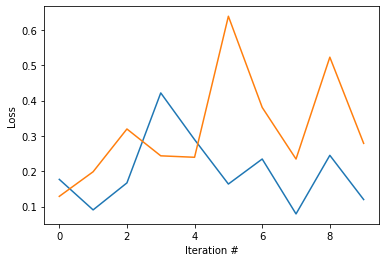

In [297]:
plot(np.vstack([train_loss, scratch_train_loss]).T)
xlabel('Iteration #')
ylabel('Loss')

Text(0, 0.5, 'Accuracy')

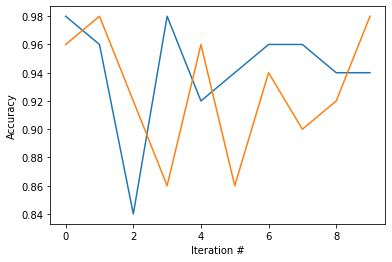

In [320]:
plot(np.vstack([train_acc, scratch_train_acc]).T)
xlabel('Iteration #')
ylabel('Accuracy')

>save model to google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!mkdir "/content/drive/My Drive/Colab Notebooks/Trained_Model"

In [0]:
!mv "/content/caffe/models/finetune_flickr_style/finetune_flickr_style_iter_40000.caffemodel"  "/content/drive/My Drive/Colab Notebooks/Trained_Model/"

#### test accuracy

Let's now test the end-to-end finetuned models.  Since all layers have been optimized for the style recognition task at hand, we expect both nets to get better results than the ones above, which were achieved by nets with only their classifier layers trained for the style task (on top of either ImageNet pretrained or randomly initialized weights).

In [315]:
test_net, accuracy = eval_style_net(style_weights_ft)
print ('Accuracy, finetuned from ImageNet initialization: %3.1f%%' % (100*accuracy, ))
scratch_test_net, scratch_accuracy = eval_style_net(scratch_style_weights_ft)
print ('Accuracy, finetuned from   random initialization: %3.1f%%' % (100*scratch_accuracy, ))

<class 'caffe.proto.caffe_pb2.NetParameter'>
Accuracy, finetuned from ImageNet initialization: 51.6%
<class 'caffe.proto.caffe_pb2.NetParameter'>
Accuracy, finetuned from   random initialization: 49.2%


##### Test image from training set

We'll first look back at the image we started with and check our end-to-end trained model's predictions.

top 5 predicted style labels = 
	(1) 100.00% Pastel
	(2)  0.00% Melancholy
	(3)  0.00% Detailed
	(4)  0.00% Noir
	(5)  0.00% HDR


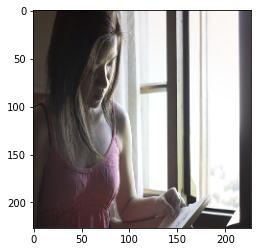

In [319]:
plt.imshow(deprocess_net_image(image))
disp_style_preds(test_net, image)

##### Pick an image from the test set

Whew, that looks a lot better than before!  But note that this image was from the training set, so the net got to see its label at training time.

Finally, we'll pick an image from the test set (an image the model hasn't seen) and look at our end-to-end finetuned style model's predictions for it.

actual label = HDR


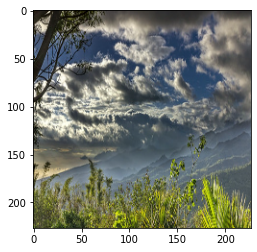

In [321]:
batch_index = 1
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print ('actual label =', style_labels[int(test_net.blobs['label'].data[batch_index])])

In [322]:
disp_style_preds(test_net, image)

top 5 predicted style labels = 
	(1) 100.00% HDR
	(2)  0.00% Melancholy
	(3)  0.00% Detailed
	(4)  0.00% Pastel
	(5)  0.00% Noir


We can also look at the predictions of the network trained from scratch.  We see that in this case, the scratch network also predicts the correct label for the image (*Pastel*), but is much less confident in its prediction than the pretrained net.

In [323]:
disp_style_preds(scratch_test_net, image)

top 5 predicted style labels = 
	(1) 100.00% HDR
	(2)  0.00% Detailed
	(3)  0.00% Melancholy
	(4)  0.00% Pastel
	(5)  0.00% Noir


Of course, we can again look at the ImageNet model's predictions for the above image:

In [324]:
disp_imagenet_preds(imagenet_net, image)

top 5 predicted ImageNet labels = 
	(1) 18.70% n09468604 valley, vale
	(2) 18.45% n09332890 lakeside, lakeshore
	(3)  7.94% n09428293 seashore, coast, seacoast, sea-coast
	(4)  7.48% n09399592 promontory, headland, head, foreland
	(5)  7.40% n09193705 alp


So we did finetuning and it is awesome. Let's take a look at what kind of results we are able to get with a longer, more complete run of the style recognition dataset. Note: the below URL might be occasionally down because it is run on a research machine.

http://demo.vislab.berkeleyvision.org/